In [173]:
import os
from tqdm import tqdm
import numpy as np
import soundfile as sf
import pickle
import librosa
import numpy as np
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
def split_audio_file(file_path, output_dir, segment_length=5):
    """
    Split an audio file into segments and save them to an output directory.

    Parameters:
    - file_path (str): Path to the audio file.
    - output_dir (str): Directory to save the audio segments.
    - segment_length (float): Duration of each segment in seconds.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Calculate the number of samples per segment
    samples_per_segment = int(segment_length * sr)

    # Split the audio into segments and save them
    for i, start in enumerate(range(0, len(y), samples_per_segment)):
        end = start + samples_per_segment
        segment = y[start:end]
        segment_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(file_path))[0]}_{i}.wav")
        sf.write(segment_path, segment, sr)

In [175]:
def split_audio_files_in_directory(input_directory, output_directory, segment_length=5):
    """
    Split audio files in a directory into segments and save them to an output directory.

    Parameters:
    - input_directory (str): Path to the directory containing audio files.
    - output_directory (str): Directory to save the audio segments.
    - segment_length (float): Duration of each segment in seconds.
    """
    os.makedirs(output_directory, exist_ok=True)
        
    for fname in tqdm(os.listdir(input_directory), desc='Splitting audio files'):
        file_path = os.path.join(input_directory, fname)
        split_audio_file(file_path, output_directory, segment_length)

In [176]:
input_directory = 'C:\\Users\\DELL\\OneDrive\\Desktop\\prj 2\\result'
output_directory = 'C:\\Users\\DELL\\OneDrive\\Desktop\\prj 2\\result_5sec'

split_audio_files_in_directory(input_directory, output_directory, segment_length=5)

Splitting audio files: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


In [177]:
def extract_features(y, sr=22050, n_fft=512, hop_length=512):
    # Compute the magnitude spectrogram
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    features = {
        'centroid': librosa.feature.spectral_centroid(S=S, sr=sr).ravel(),
        'rmse': librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length).ravel(),
        'zcr': librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel(),
        'bandwidth': librosa.feature.spectral_bandwidth(S=S, sr=sr).ravel(),
        'flatness': librosa.feature.spectral_flatness(S=S).ravel(),
        'rolloff': librosa.feature.spectral_rolloff(S=S, sr=sr).ravel()
    }

    # MFCC treatment
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length)
    for idx, v_mfcc in enumerate(mfcc):
        features[f'mfcc_{idx+1}'] = v_mfcc.ravel()
        

    # Get statistics from the vectors
    def get_feature_stats(features):
        result = {}
        for k, v in features.items():
            result[f'{k}_variance'] = np.var(v)
            result[f'{k}_mean'] = np.mean(v)
        return result

    dict_agg_features = get_feature_stats(features)
    tempo= librosa.beat.tempo(y=y, sr=sr, hop_length=hop_length)
    dict_agg_features['tempo'] = tempo
    
    return dict_agg_features

In [178]:
def make_data():
    arr_features=[]
    os.chdir('C:\\Users\\DELL\\OneDrive\\Desktop\\prj 2\\result_5sec')
    for fname in tqdm(os.listdir()):
        y, sr = librosa.load(fname, duration=30)
        dict_features = extract_features(y=y, sr=sr)
        arr_features.append(dict_features)

    df = pd.DataFrame(data=arr_features)
    print(df.head())
    print(df.shape)
    os.chdir('C:\\Users\\DELL\\OneDrive\\Desktop\\prj 2')
    df.to_csv('result_data.csv', index=False)

In [179]:
make_data()

  0%|                                                                                           | 0/57 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_18188\1332652160.py:29: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo= librosa.beat.tempo(y=y, sr=sr, hop_length=hop_length)
100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.38it/s]

   centroid_variance  centroid_mean  rmse_variance  rmse_mean  zcr_variance  \
0       1.745968e+06    2057.707727       0.002660   0.107068      0.011779   
1       1.163760e+06    1724.026075       0.002136   0.142341      0.004903   
2       1.261443e+05    1983.261544       0.001569   0.201625      0.000965   
3       2.697167e+05    2122.868984       0.001667   0.207193      0.000954   
4       1.632434e+05    1893.409113       0.002195   0.193324      0.000845   

   zcr_mean  bandwidth_variance  bandwidth_mean  flatness_variance  \
0  0.099275       554966.345140     2202.209689           0.035892   
1  0.077040       450665.367660     2066.582167           0.000362   
2  0.095875        57934.409229     2186.691709           0.000388   
3  0.091200       180540.112869     2356.545227           0.000347   
4  0.089283       105960.102270     2083.315556           0.000404   

   flatness_mean  ...  mfcc_16_mean  mfcc_17_variance  mfcc_17_mean  \
0       0.057386  ...     -2.2769

In [180]:
model_path = 'xgb_model.pkl'

In [181]:
data = pd.read_csv('result_data.csv')

data['tempo'] = data['tempo'].str.strip('[]').astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

X = pd.DataFrame(X_scaled, columns=data.columns)
X.head()

,centroid_variance,centroid_mean,rmse_variance,rmse_mean,zcr_variance,zcr_mean,bandwidth_variance,bandwidth_mean,flatness_variance,flatness_mean,...,mfcc_16_mean,mfcc_17_variance,mfcc_17_mean,mfcc_18_variance,mfcc_18_mean,mfcc_19_variance,mfcc_19_mean,mfcc_20_variance,mfcc_20_mean,tempo
0,5.164146,0.161735,0.508447,-2.619068,5.307367,0.299652,4.423480,-0.030686,2.928515,2.896394,...,-2.304631,1.250392,-1.317125,0.579030,-1.352586,4.786257,-2.627315,3.459187,-2.282396,-0.284302
1,3.185703,-0.775468,-0.096892,-1.501809,1.777209,-0.794108,3.363842,-0.515375,-0.171358,-0.960003,...,-0.671072,1.079211,-0.313466,1.691246,-2.238797,1.799558,-0.813133,1.732355,-1.875134,-0.284302
2,-0.340297,-0.047360,-0.750261,0.375947,-0.244797,0.132408,-0.626081,-0.086142,-0.169064,-0.238705,...,0.564290,1.355843,0.602286,0.989853,1.019802,0.771925,0.955959,1.760583,0.292012,0.096907
3,0.147587,0.344752,-0.637256,0.552310,-0.250287,-0.097553,0.619523,0.520860,-0.172680,0.104302,...,0.251735,-0.646017,-0.258987,-0.922383,-1.040323,-0.613678,-0.157238,0.185997,-0.209585,0.096907
4,-0.214228,-0.299726,-0.028143,0.113024,-0.306483,-0.191850,-0.138167,-0.455575,-0.167671,-0.364913,...,0.488837,-1.121783,0.059564,-0.695552,0.203512,-1.284353,0.472643,-0.853460,0.348888,0.522964


In [182]:
import joblib
model = joblib.load(model_path)

In [183]:
genre_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
pred = model.predict(X)

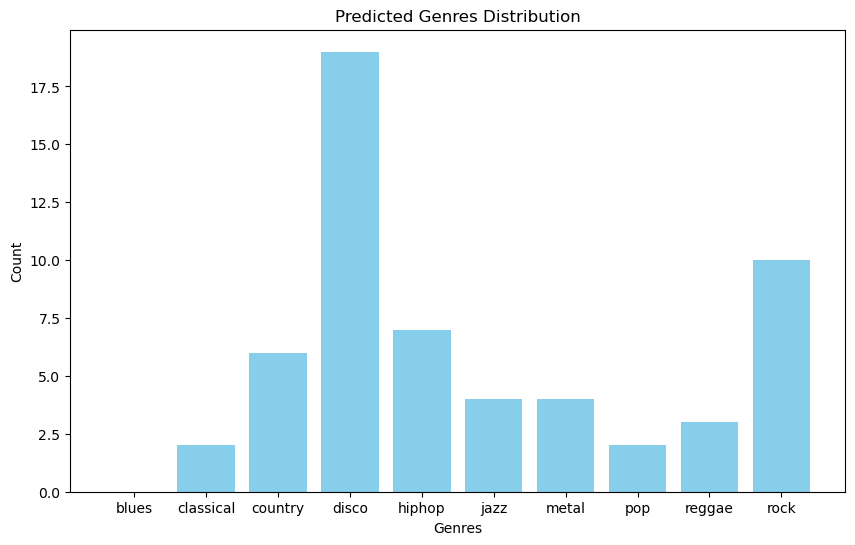

In [184]:
counts = [list(pred).count(i) for i in range(len(genre_names))]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(genre_names, counts, color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Predicted Genres Distribution')
plt.show()

In [84]:
duration=30, 
hop_length_seconds=0.14

# Set audio file path
audio_file = audio  # Replace with the path to your audio file

# Define parameters
duration = 30
hop_length_seconds = 0.14

# Load audio and trim
y, sr = librosa.load(audio_file, duration=duration)
audio_file, _ = librosa.effects.trim(y)


# Zero crossings
zero_crossings = np.sum(librosa.zero_crossings(audio_file, pad=False))
zcr_mean = np.mean(zero_crossings)
zcr_var = np.var(zero_crossings)

# Tempo
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

# Spectral centroid
spectral_centroids = librosa.feature.spectral_centroid(y=audio_file, sr=sr)
centroid_mean = np.mean(spectral_centroids)
centroid_var = np.var(spectral_centroids)

# Spectral bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_file, sr=sr)
bandwidth_mean = np.mean(spectral_bandwidth)
bandwidth_var = np.var(spectral_bandwidth)

# Spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_file, sr=sr).flatten()
rolloff_mean = np.mean(spectral_rolloff)
rolloff_var = np.var(spectral_rolloff)

# MFCCs
mfccs = librosa.feature.mfcc(y=audio_file, sr=sr)
mfccs_mean = np.mean(mfccs, axis=1)[:20]
mfccs_var = np.var(mfccs, axis=1)[:20]

mfccs_combined = np.concatenate([mfccs_mean, mfccs_var])


column_names = []
for i in range(1, 21):
    column_names.append('mfcc_'+ str(i)+'_mean')
for i in range(1, 21):    
    column_names.append('mfcc_'+ str(i)+'_var')

# Create DataFrame from the concatenated array
df_combined = pd.DataFrame(mfccs_combined.reshape(1, -1), columns=column_names)

# Root Mean Square (RMS)
rms = librosa.feature.rms(y=audio_file)
rmse_mean = np.mean(rms)
rmse_var = np.var(rms)

features_dict = {
    'chroma_stft_mean':chromagram_mean, 'chroma_stft_var':chromagram_var,
    'rms_mean':rms_mean, 'rms_var':rms_var,
    'spectral_centroid_mean': spectral_centroids_mean,
    'spectral_centroid_var': spectral_centroids_var,
    'spectral_bandwidth_mean': spectral_bandwidth_mean,
    'spectral_bandwidth_var': spectral_bandwidth_var,
    'rolloff_mean': spectral_rolloff_mean,
    'rolloff_var': spectral_rolloff_var,
    'zero_crossing_rate_mean': zero_crossings_mean,
    'zero_crossing_rate_var': zero_crossings_var,
    'harmony_mean': harm_mean, 'harmony_var': harm_var,
    'perceptr_mean': perc_mean, 'perceptr_var': perc_var,
    'tempo': tempo,
}

Adata=pd.DataFrame(features_dict)

NameError: name 'audio' is not defined

In [4]:
Adata

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo
0,0.312340,0.075652,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
1,0.112069,0.022680,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
2,0.112550,0.045090,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
3,0.196059,0.030245,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
4,0.474231,0.154122,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
5,0.197464,0.029947,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
6,0.156269,0.054016,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
7,0.162618,0.070047,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
8,0.107420,0.027760,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688
9,0.102940,0.049688,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688


In [5]:
df_combined

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
0,-318.625183,110.495079,7.511939,45.968998,7.523643,-0.337356,-8.571406,1.963756,6.286367,-3.868171,...,94.302322,92.622566,75.028023,99.463524,93.408035,67.497963,79.5224,74.666626,96.860847,107.00119


In [6]:
df_combined.columns

Index(['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean',
       'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean',
       'mfcc11_mean', 'mfcc12_mean', 'mfcc13_mean', 'mfcc14_mean',
       'mfcc15_mean', 'mfcc16_mean', 'mfcc17_mean', 'mfcc18_mean',
       'mfcc19_mean', 'mfcc20_mean', 'mfcc1_var', 'mfcc2_var', 'mfcc3_var',
       'mfcc4_var', 'mfcc5_var', 'mfcc6_var', 'mfcc7_var', 'mfcc8_var',
       'mfcc9_var', 'mfcc10_var', 'mfcc11_var', 'mfcc12_var', 'mfcc13_var',
       'mfcc14_var', 'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_var',
       'mfcc19_var', 'mfcc20_var'],
      dtype='object')

In [7]:
mfccs_mean

array([-3.1862518e+02,  1.1049508e+02,  7.5119386e+00,  4.5968998e+01,
        7.5236430e+00, -3.3735585e-01, -8.5714064e+00,  1.9637556e+00,
        6.2863669e+00, -3.8681710e+00, -1.2785882e+01,  2.3592288e+00,
       -1.4849262e+00, -4.6843343e+00, -1.3415989e+01,  5.6821817e-01,
       -1.1000390e+01, -1.0540000e+01, -3.9400036e+00, -2.9003462e-01],
      dtype=float32)

In [8]:
df1=Adata.iloc[0]
df11=pd.DataFrame(df1)
DF=df11.T
DF

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo
0,0.31234,0.075652,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,38443.0,0.0,0.000003,0.001279,-0.000002,0.000042,143.554688


In [9]:
Features = pd.concat([DF,df_combined], axis=1)
Features

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
0,0.31234,0.075652,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,...,94.302322,92.622566,75.028023,99.463524,93.408035,67.497963,79.5224,74.666626,96.860847,107.00119


In [10]:
Features.columns

Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean',
       'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean',
       'mfcc11_mean', 'mfcc12_mean', 'mfcc13_mean', 'mfcc14_mean',
       'mfcc15_mean', 'mfcc16_mean', 'mfcc17_mean', 'mfcc18_mean',
       'mfcc19_mean', 'mfcc20_mean', 'mfcc1_var', 'mfcc2_var', 'mfcc3_var',
       'mfcc4_var', 'mfcc5_var', 'mfcc6_var', 'mfcc7_var', 'mfcc8_var',
       'mfcc9_var', 'mfcc10_var', 'mfcc11_var', 'mfcc12_var', 'mfcc13_var',
       'mfcc14_var', 'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_var',
       'mfcc19_var', 'mfcc20_var'],
      dtype='obj

In [11]:
newData={
    'chroma_stft_mean': chromagram_mean,
    'chroma_stft_var': chromagram_var,
    'rms_mean': rms_mean,
    'rms_var': rms_var,
    'spectral_centroid_mean': spectral_centroids_mean,
    'spectral_centroid_var': spectral_centroids_var,
    'spectral_bandwidth_mean': spectral_bandwidth_mean,
    'spectral_bandwidth_var': spectral_bandwidth_var,
    'rolloff_mean': spectral_rolloff_mean,
    'rolloff_var': spectral_rolloff_var,
    'zero_crossing_rate_mean': zero_crossings_mean,
    'zero_crossing_rate_var': zero_crossings_var,
    'harmony_mean': harm_mean,
    'harmony_var': harm_var,
    'perceptr_mean': perc_mean,
    'perceptr_var': perc_var,
    'tempo': tempo,
    'mfcc1_mean': df_combined['mfcc1_mean'].values[0],
    'mfcc1_var': df_combined['mfcc1_var'].values[0],
    'mfcc2_mean': df_combined['mfcc2_mean'].values[0],
    'mfcc2_var': df_combined['mfcc2_var'].values[0],
    'mfcc3_mean': df_combined['mfcc3_mean'].values[0],
    'mfcc3_var': df_combined['mfcc3_var'].values[0],
    'mfcc4_mean': df_combined['mfcc4_mean'].values[0],
    'mfcc4_var': df_combined['mfcc4_var'].values[0],
    'mfcc5_mean': df_combined['mfcc5_mean'].values[0],
    'mfcc5_var': df_combined['mfcc5_var'].values[0],
    'mfcc6_mean': df_combined['mfcc6_mean'].values[0],
    'mfcc6_var': df_combined['mfcc6_var'].values[0],
    'mfcc7_mean': df_combined['mfcc7_mean'].values[0],
    'mfcc7_var': df_combined['mfcc7_var'].values[0],
    'mfcc8_mean': df_combined['mfcc8_mean'].values[0],
    'mfcc8_var': df_combined['mfcc8_var'].values[0],
    'mfcc9_mean': df_combined['mfcc9_mean'].values[0],
    'mfcc9_var': df_combined['mfcc9_var'].values[0],
    'mfcc10_mean': df_combined['mfcc10_mean'].values[0],
    'mfcc10_var': df_combined['mfcc10_var'].values[0],
    'mfcc11_mean': df_combined['mfcc11_mean'].values[0],
    'mfcc11_var': df_combined['mfcc11_var'].values[0],
    'mfcc12_mean': df_combined['mfcc12_mean'].values[0],
    'mfcc12_var': df_combined['mfcc12_var'].values[0],
    'mfcc13_mean': df_combined['mfcc13_mean'].values[0],
    'mfcc13_var': df_combined['mfcc13_var'].values[0],
    'mfcc14_mean': df_combined['mfcc14_mean'].values[0],
    'mfcc14_var': df_combined['mfcc14_var'].values[0],
    'mfcc15_mean': df_combined['mfcc15_mean'].values[0],
    'mfcc15_var': df_combined['mfcc15_var'].values[0],
    'mfcc16_mean': df_combined['mfcc16_mean'].values[0],
    'mfcc16_var': df_combined['mfcc16_var'].values[0],
    'mfcc17_mean': df_combined['mfcc17_mean'].values[0],
    'mfcc17_var': df_combined['mfcc17_var'].values[0],
    'mfcc18_mean': df_combined['mfcc18_mean'].values[0],
    'mfcc18_var': df_combined['mfcc18_var'].values[0],
    'mfcc19_mean': df_combined['mfcc19_mean'].values[0],
    'mfcc19_var': df_combined['mfcc19_var'].values[0],
    'mfcc20_mean': df_combined['mfcc20_mean'].values[0],
    'mfcc20_var': df_combined['mfcc20_var'].values[0]
}

In [12]:
New = pd.DataFrame(newData)
NEw=New.iloc[0]
NEW=pd.DataFrame(NEw)
NEW=NEW.T

In [13]:
NEW

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.31234,0.075652,0.034479,0.000225,1462.133117,237851.79935,1939.323084,127969.963486,3100.516987,1.224596e+06,...,0.568218,67.497963,-11.00039,79.5224,-10.54,74.666626,-3.940004,96.860847,-0.290035,107.00119


In [18]:
true_labels = [6,6,6,6,6,6,6,6,6,6,6,6]

def predict_genre(features, model_path='xgb_model.pkl'):
    # Load the pre-trained XGBoost model
    xgb_model = joblib.load(model_path)
    genre_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
   
    # Make prediction
    genre_pred = xgb_model.predict(features)
    predicted_name = genre_names[genre_pred[0]]
    
    return genre_pred, predicted_name
        

In [19]:
xgb_model_path = 'xgb_model.pkl'
genre_pred,predicted_name = predict_genre(NEW, xgb_model_path)

In [20]:
print("Predicted genre label:", genre_pred)

Predicted genre label: [4]


In [21]:
print("Predicted genre name:", predicted_name)

Predicted genre name: hiphop
